In [1]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from tqdm import tqdm

from metrics import MSE
from network import CAM_PE, CAM, PE, NoEnc

ground truth


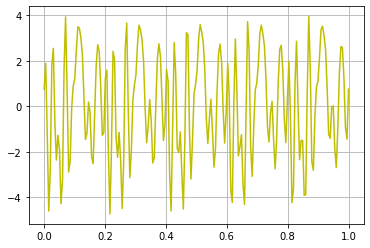

In [2]:
#set random seed
random_seed = 31210
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#create synthetic target function
x = torch.linspace(0, 1, steps = 200)
y = torch.zeros_like(x)
n_modes = 10
f = 5
pi = 3.14159
for i in range(n_modes):
    phase = torch.rand(1) * 2 * pi
    y += torch.sin(2 * pi * f * x + phase)
    f += 5
x, y = torch.unsqueeze(x.to(device), 1), torch.unsqueeze(y.to(device), 1)

#visualize target ground truth function
print("ground truth")
plt.plot(x.cpu(), y.cpu(), 'y')
plt.grid(True)

In [7]:
# model
net = CAM_PE(in_feats = 1, hidden_feats = 64, n_hidden_layers = 3, out_feats = 1)
# Other models
# net = CAM(in_feats = 1, hidden_feats = 64, n_hidden_layers = 3, out_feats = 1)
# net = PE(in_feats = 1, hidden_feats = 64, n_hidden_layers = 3, out_feats = 1)
# net = NoEnc(in_feats = 1, hidden_feats = 64, n_hidden_layers = 3, out_feats = 1)
net.to(device)
print(net)

lr = 1e-3
epochs = 1500
# loss function
mse = MSE()
optimizer = optim.Adam(net.parameters(), lr = lr)
#training loop
for e in tqdm(range(epochs)):
    optimizer.zero_grad()               # clear gradients
    yhat = net(x)                       # forward prop.
    loss = mse(yhat, y)                 # compute loss
    loss.backward()                     # backward prop.
    optimizer.step()                    # update weights
    if e%1000 ==0:
        print("MSE:", loss.detach().cpu().numpy())
print("MSE:", loss.detach().cpu().numpy())
print()
print("training done")

  2%|▏         | 28/1500 [00:00<00:05, 279.15it/s]

CAM(
  (net_last): Linear(in_features=64, out_features=1, bias=True)
  (net): ModuleList(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=64, bias=True)
  )
  (affine): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 1x2x64x1 (GPU 0)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 1x2x64x1 (GPU 0)]
      (2): Parameter containing: [torch.cuda.FloatTensor of size 1x2x64x1 (GPU 0)]
      (3): Parameter containing: [torch.cuda.FloatTensor of size 1x2x64x1 (GPU 0)]
  )
)
MSE: 4.9751573


 70%|███████   | 1055/1500 [00:03<00:01, 274.76it/s]

MSE: 0.08329481


100%|██████████| 1500/1500 [00:05<00:00, 276.78it/s]

MSE: 0.08168531

training done


In [ ]:
#visualize output
ax = []
fig = plt.figure(figsize = (36, 10))

with torch.no_grad():
    net.eval()
    yhat = net(x)           # forward prop.
    ax.append(fig.add_subplot(2, 4, 2))
    ax[0].plot(x.cpu(), y.cpu(), 'y--')
    ax[0].plot(x.cpu(), yhat.cpu(), 'g')
    plt.ylim(-5,5)
    plt.grid(True)